In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [38]:
df = pd.read_feather('/content/drive/MyDrive/ds-phase-2/nlp_project/tg_channels.feather')
df

,url,date,content,label
0,https://t.me/s/russianmoda/5961,2023-09-17 17:09:06+00:00,Широкие бедра всегда считались роскошью и прид...,мода
1,https://t.me/s/russianmoda/5957,2023-09-17 12:09:06+00:00,"Не знаю как у вас, но у меня ни одна осень не ...",мода
2,https://t.me/s/russianmoda/5951,2023-09-17 06:09:06+00:00,Осенью настроение немножко ухудшается. Этому с...,мода
3,https://t.me/s/russianmoda/5939,2023-09-16 17:09:06+00:00,"Кардиган очень коварен в стилизации, поэтому е...",мода
4,https://t.me/s/russianmoda/5935,2023-09-16 12:09:06+00:00,Трикотажные костюмы часто ассоциируются с брюк...,мода
...,...,...,...,...
2895,https://t.me/s/crypto_dancing/848,2023-06-29 17:30:58+00:00,Mastercard планирует создать магазин для блокч...,крипта
2896,https://t.me/s/crypto_dancing/847,2023-06-29 13:01:21+00:00,Hang Seng Investment Management рассматривает ...,крипта
2897,https://t.me/s/crypto_dancing/846,2023-06-28 16:31:03+00:00,Аналитик Bloomberg оценил шансы BlackRock на з...,крипта
2898,https://t.me/s/crypto_dancing/845,2023-06-28 12:00:47+00:00,Профессия блокчейн-разработчика✏️ ♾ Блокчейн-п...,крипта


In [39]:
uniq_label = df['label'].unique()
uniq_label

array(['мода', 'спорт', 'технологии', 'финансы', 'крипта'], dtype=object)

In [ ]:
class_counts = df['label'].value_counts()
print(class_counts)
# дисбаланса классов нет

label
мода          600
технологии    600
финансы       600
крипта        600
спорт         500
Name: count, dtype: int64


===================================TF-IDF

TF-IDF + LogisticRegression Accuracy: 0.8344827586206897
=== ОСНОВНЫЕ МЕТРИКИ ===
Accuracy: 0.8345
F1-score (macro): 0.8337
F1-score (weighted): 0.8348

=== ДЕТАЛЬНЫЙ REPORT ПО КЛАССАМ ===
              precision    recall  f1-score   support

        мода       0.87      0.91      0.89       120
       спорт       0.87      0.83      0.85       120
  технологии       0.82      0.78      0.80       100
     финансы       0.74      0.82      0.78       120
      крипта       0.88      0.82      0.85       120

    accuracy                           0.83       580
   macro avg       0.84      0.83      0.83       580
weighted avg       0.84      0.83      0.83       580



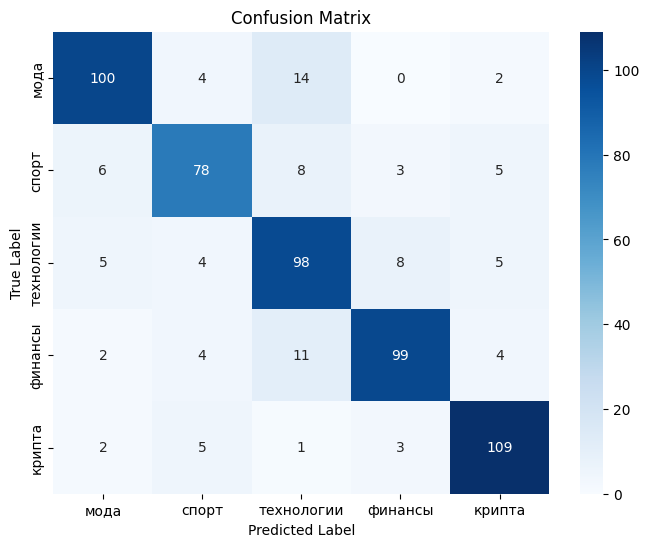

=== МЕТРИКИ ПО КЛАССАМ ===
        Class  Precision    Recall  F1-Score  Support
0        мода   0.872000  0.908333  0.889796      120
1       спорт   0.869565  0.833333  0.851064      120
2  технологии   0.821053  0.780000  0.800000      100
3     финансы   0.742424  0.816667  0.777778      120
4      крипта   0.876106  0.825000  0.849785      120
Log Loss: 0.7498
ROC-AUC (macro): 0.9695

Топ 10 признаков для класса 'крипта':
['согласно', 'криптовалюты', 'сети', 'токен', 'токенов', 'млн', 'биткоина', 'криптовалют', 'биткоин', 'чат']

Топ 10 признаков для класса 'мода':
['носить', 'коллекция', 'моды', 'бренд', 'образов', 'коллекции', 'платье', 'образы', 'бренда', 'образ']

Топ 10 признаков для класса 'спорт':
['тренер', 'месси', 'тренера', 'роналду', 'сборной', 'матча', 'гол', 'матче', 'после', 'матч']

Топ 10 признаков для класса 'технологии':
['код', 'пока', 'как', 'для', 'тут', 'про', 'видео', 'вот', 'ии', 'можно']

Топ 10 признаков для класса 'финансы':
['года', 'ставки', 'экономик

In [ ]:
# Предобработка текста для классических моделей
def preprocess_text(text):
    if isinstance(text, str):
        # Приведение к нижнему регистру
        text = text.lower()
        # Удаление спецсимволов и цифр
        text = re.sub(r'[^а-яё\s]', '', text)
        # Удаление лишних пробелов
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Подготовка данных
df['cleaned_content'] = df['content'].apply(preprocess_text)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_content'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# TF-IDF векторизация
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Обучение модели
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Предсказания
lr_pred = lr_model.predict(X_test_tfidf)
print("TF-IDF + LogisticRegression Accuracy:", accuracy_score(y_test, lr_pred))


from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Предсказания
lr_pred = lr_model.predict(X_test_tfidf)
lr_pred_proba = lr_model.predict_proba(X_test_tfidf)

# Базовые метрики
accuracy = accuracy_score(y_test, lr_pred)
f1_macro = f1_score(y_test, lr_pred, average='macro')
f1_weighted = f1_score(y_test, lr_pred, average='weighted')

print("=== ОСНОВНЫЕ МЕТРИКИ ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")
print()

# Детальный отчет по классам
print("=== ДЕТАЛЬНЫЙ REPORT ПО КЛАССАМ ===")
print(classification_report(y_test, lr_pred, target_names=df['label'].unique()))

# Матрица ошибок
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, lr_pred, df['label'].unique())

# Метрики по каждому классу
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, lr_pred)

print("=== МЕТРИКИ ПО КЛАССАМ ===")
metrics_df = pd.DataFrame({
    'Class': df['label'].unique(),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print(metrics_df)

# Дополнительные метрики
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Log Loss (только если есть вероятности)
try:
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    log_loss_value = log_loss(y_test_bin, lr_pred_proba)
    print(f"Log Loss: {log_loss_value:.4f}")
except Exception as e:
    print(f"Log Loss calculation skipped: {e}")

# ROC-AUC для многоклассовой классификации
try:
    roc_auc = roc_auc_score(y_test_bin, lr_pred_proba, multi_class='ovr', average='macro')
    print(f"ROC-AUC (macro): {roc_auc:.4f}")
except Exception as e:
    print(f"ROC-AUC calculation skipped: {e}")

# Топ признаков для интерпретации модели
def get_top_features(vectorizer, model, feature_names, n=10):
    """Показывает топ признаков для каждого класса"""
    for i, class_name in enumerate(model.classes_):
        top_features = np.argsort(model.coef_[i])[-n:]
        print(f"\nТоп {n} признаков для класса '{class_name}':")
        print([feature_names[j] for j in top_features])

# Получаем названия фич
feature_names = tfidf.get_feature_names_out()
get_top_features(tfidf, lr_model, feature_names, n=10)

==========================================================LSTM

Epoch 1: 100%|██████████| 72/72 [00:07<00:00,  9.40it/s]


Epoch 1: Train Loss 1.5385, Val Loss 1.4354, Train F1 0.2900, Val F1 0.3606


Epoch 2: 100%|██████████| 72/72 [00:07<00:00,  9.20it/s]


Epoch 2: Train Loss 1.1464, Val Loss 1.2461, Train F1 0.5725, Val F1 0.4750


Epoch 3: 100%|██████████| 72/72 [00:07<00:00,  9.25it/s]


Epoch 3: Train Loss 0.7392, Val Loss 1.1465, Train F1 0.7506, Val F1 0.5671


Epoch 4: 100%|██████████| 72/72 [00:07<00:00, 10.01it/s]


Epoch 4: Train Loss 0.3845, Val Loss 1.1169, Train F1 0.8875, Val F1 0.5974


Epoch 5: 100%|██████████| 72/72 [00:07<00:00,  9.48it/s]


Epoch 5: Train Loss 0.1629, Val Loss 1.1740, Train F1 0.9643, Val F1 0.6104
Accuracy: 0.6077057793345009
Precision (macro): 0.6131408168613027
Recall (macro): 0.6088761507990029
F1-macro: 0.6104119362605049


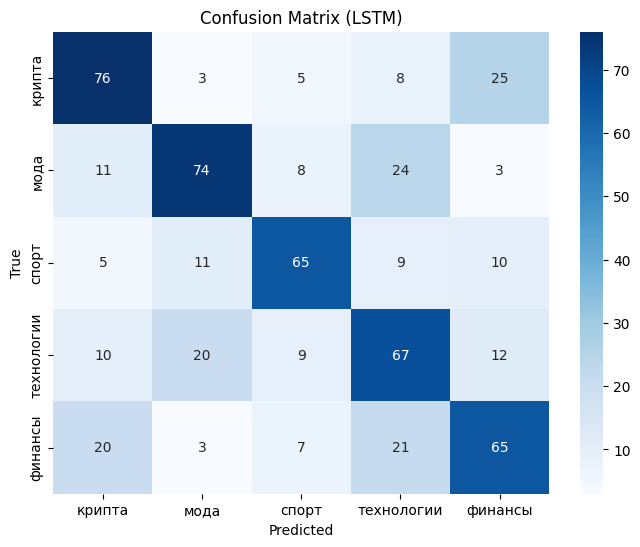

In [12]:
import torch
import torch.nn as nn
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import re

# Датасет
df = pd.read_feather('/content/drive/MyDrive/ds-phase-2/nlp_project/tg_channels.feather')
df = df.dropna(subset=['content', 'label'])

# Кодируем метки
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
num_labels = len(label_encoder.classes_)


# Простая очистка текста
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_content'] = df['content'].apply(preprocess_text)
#Токенизация
tokenized_texts = [t.lower().split() for t in df['cleaned_content']]
# Строим словарь
counter = Counter([token for text in tokenized_texts for token in text])
vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common())}
vocab["<pad>"] = 0
vocab["<unk>"] = 1
# Индексируем тексты
indexed_texts = [torch.tensor([vocab.get(t, vocab["<unk>"]) for t in text]) for text in tokenized_texts]

# Паддинг до max_len
max_len = 50
def pad_seq(seq):
    if len(seq) < max_len:
        return torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)])
    else:
        return seq[:max_len].long()

padded_texts = torch.stack([pad_seq(seq) for seq in indexed_texts])


labels = torch.tensor(df['label_id'].values)
X_train, X_test, y_train, y_test = train_test_split(
    padded_texts.long(), labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


#лстм модель

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=1, bidirectional=True, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        return self.fc(self.dropout(hidden))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=128,
    output_dim=num_labels,
    n_layers=1,
    bidirectional=True,
    dropout=0.0
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

for epoch in range(num_epochs):
    # TRAIN
    model.train()
    total_loss = 0
    train_preds, train_labels_epoch = [], []

    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        train_preds.extend(preds)
        train_labels_epoch.extend(y_batch.cpu().numpy())

    train_loss = total_loss / len(train_loader)
    train_f1 = f1_score(train_labels_epoch, train_preds, average="macro")

    # VALIDATION
    model.eval()
    val_preds, val_labels_epoch = [], []
    total_val_loss = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels_epoch.extend(y_batch.cpu().numpy())

    val_loss = total_val_loss / len(val_loader)
    val_f1 = f1_score(val_labels_epoch, val_preds, average="macro")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Train F1 {train_f1:.4f}, Val F1 {val_f1:.4f}")


#Метрики

acc = accuracy_score(val_labels_epoch, val_preds)
prec = precision_score(val_labels_epoch, val_preds, average='macro')
rec = recall_score(val_labels_epoch, val_preds, average='macro')
f1 = f1_score(val_labels_epoch, val_preds, average='macro')

print("Accuracy:", acc)
print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-macro:", f1)

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_labels_epoch, val_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (LSTM)")
plt.show()

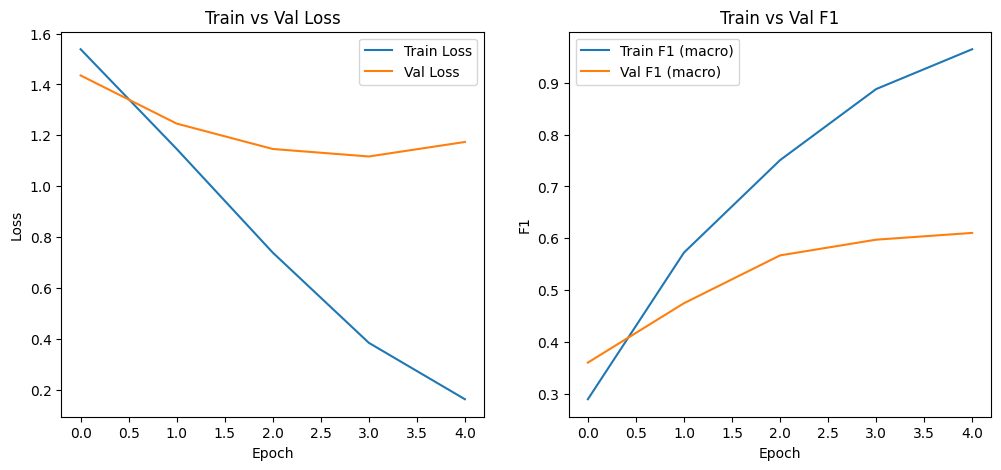

In [14]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Train F1 (macro)')
plt.plot(val_f1s, label='Val F1 (macro)')
plt.title('Train vs Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.show()

In [13]:
# Функция для предсказания
def predict(text, max_len=50):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)
    tokens = text.split()
    indices = [vocab.get(t, vocab["<unk>"]) for t in tokens]
    if len(indices) < max_len:
        indices += [vocab["<pad>"]] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    tensor = torch.tensor([indices])
    with torch.no_grad():
        out = model(tensor)
    pred_id = out.argmax(dim=1).item()
    return label_encoder.inverse_transform([pred_id])[0]

# Пример проверки
example_text = "Сегодня биткоин резко вырос в цене"
print("Текст:", example_text)
print("Предсказанный класс:", predict(example_text))

Текст: Сегодня биткоин резко вырос в цене
Предсказанный класс: крипта


=====================================rubert-tiny2

In [40]:
df

,url,date,content,label
0,https://t.me/s/russianmoda/5961,2023-09-17 17:09:06+00:00,Широкие бедра всегда считались роскошью и прид...,мода
1,https://t.me/s/russianmoda/5957,2023-09-17 12:09:06+00:00,"Не знаю как у вас, но у меня ни одна осень не ...",мода
2,https://t.me/s/russianmoda/5951,2023-09-17 06:09:06+00:00,Осенью настроение немножко ухудшается. Этому с...,мода
3,https://t.me/s/russianmoda/5939,2023-09-16 17:09:06+00:00,"Кардиган очень коварен в стилизации, поэтому е...",мода
4,https://t.me/s/russianmoda/5935,2023-09-16 12:09:06+00:00,Трикотажные костюмы часто ассоциируются с брюк...,мода
...,...,...,...,...
2895,https://t.me/s/crypto_dancing/848,2023-06-29 17:30:58+00:00,Mastercard планирует создать магазин для блокч...,крипта
2896,https://t.me/s/crypto_dancing/847,2023-06-29 13:01:21+00:00,Hang Seng Investment Management рассматривает ...,крипта
2897,https://t.me/s/crypto_dancing/846,2023-06-28 16:31:03+00:00,Аналитик Bloomberg оценил шансы BlackRock на з...,крипта
2898,https://t.me/s/crypto_dancing/845,2023-06-28 12:00:47+00:00,Профессия блокчейн-разработчика✏️ ♾ Блокчейн-п...,крипта


In [31]:
# bert
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from torch.utils.data import Dataset
import time
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Отключаем WandB
os.environ["WANDB_DISABLED"] = "true"
# Предобработка текста для BERT
def preprocess_bert_text(text):
    if isinstance(text, str):
        text = text.strip()
        return text
    return ""

# Подготовка данных
df['bert_content'] = df['content'].apply(preprocess_bert_text)

# Кодируем метки
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("Classes mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['bert_content'], df['label_encoded'],
    test_size=0.2, random_state=42, stratify=df['label_encoded']
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# Создаем датасет для PyTorch
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Инициализируем токенизатор и модель
model_name = "sberbank-ai/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    ignore_mismatched_sizes=True
)
model.to(device)

# Создаем датасеты
train_dataset = NewsDataset(X_train, y_train, tokenizer)
test_dataset = NewsDataset(X_test, y_test, tokenizer)

# Аргументы для обучения (совместимые с новой версией transformers)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Уменьшил для стабильности
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    report_to=None,
)

# Функция для вычисления метрик
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

# Создаем тренер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Обучаем модель
print("Starting BERT training...")
start_time = time.time()
trainer.train()
training_time = time.time() - start_time
print(f"Обучение заняло: {training_time:.2f} секунд")

# Оценка модели
print("\n=== BERT MODEL EVALUATION ===")
eval_results = trainer.evaluate()
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1-macro: {eval_results['eval_f1_macro']:.4f}")
print(f"F1-weighted: {eval_results['eval_f1_weighted']:.4f}")

# Предсказания на тестовом наборе
predictions = trainer.predict(test_dataset)
bert_pred = np.argmax(predictions.predictions, axis=1)

# Детальный отчет
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, bert_pred, target_names=label_encoder.classes_))

# Функция для предсказания на новых данных с измерением времени
def predict_bert(text, model, tokenizer, label_encoder):
    start_time = time.time()

    # Токенизация
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors='pt'
    )

    # Перенос на устройство
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Предсказание
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1)
        predicted_label = label_encoder.inverse_transform(predicted_class.cpu())[0]
        probability = torch.max(predictions).item()

    inference_time = time.time() - start_time

    return predicted_label, probability, inference_time

# Тестируем на примерах
test_texts = [
    "Биткоин достиг нового максимума на фоне роста интереса институциональных инвесторов",
    "Новая коллекция платьев от известного дизайнера представлена на неделе моды в Милане",
    "Футбольный клуб подписал контракт с бразильским нападающим за рекордную сумму",
    "Искусственный интеллект помогает ученым в разработке новых лекарств"
]

print("\n=== ТЕСТИРОВАНИЕ НА ПРИМЕРАХ ===")
for test_text in test_texts:
    pred_label, prob, inf_time = predict_bert(test_text, model, tokenizer, label_encoder)
    print(f"Текст: '{test_text}'")
    print(f"→ Класс: {pred_label}, Вероятность: {prob:.4f}, Время: {inf_time:.4f}с\n")

# # Сохраняем модель для использования в Streamlit
# print("Saving model for Streamlit...")
# trainer.save_model('./bert_news_classifier')
# tokenizer.save_pretrained('./bert_news_classifier')

# print("BERT model training completed!")

Using device: cuda
Classes mapping: {'крипта': 0, 'мода': 1, 'спорт': 2, 'технологии': 3, 'финансы': 4}
Train size: 2320, Test size: 580


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting BERT training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.199200,0.260115,0.936207,0.938361,0.936584
2,0.069900,0.257297,0.939655,0.941633,0.940135
3,0.045100,0.263523,0.943103,0.944636,0.943247


Обучение заняло: 482.02 секунд

=== BERT MODEL EVALUATION ===


Accuracy: 0.9431
F1-macro: 0.9446
F1-weighted: 0.9432

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      крипта       0.96      0.92      0.94       120
        мода       0.97      0.96      0.96       120
       спорт       0.99      0.98      0.98       100
  технологии       0.92      0.92      0.92       120
     финансы       0.90      0.95      0.92       120

    accuracy                           0.94       580
   macro avg       0.95      0.94      0.94       580
weighted avg       0.94      0.94      0.94       580


=== ТЕСТИРОВАНИЕ НА ПРИМЕРАХ ===
Текст: 'Биткоин достиг нового максимума на фоне роста интереса институциональных инвесторов'
→ Класс: крипта, Вероятность: 0.9990, Время: 0.1075с

Текст: 'Новая коллекция платьев от известного дизайнера представлена на неделе моды в Милане'
→ Класс: мода, Вероятность: 0.9991, Время: 0.0117с

Текст: 'Футбольный клуб подписал контракт с бразильским нападающим за рекордную сумму'
→ К

Классы: ['крипта' 'мода' 'спорт' 'технологии' 'финансы']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== ЭПОХА 1/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 34.98it/s]


Train Loss: 1.3408 | Val Loss: 0.9358
Train F1: 0.6309 | Val F1: 0.8349

===== ЭПОХА 2/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 54.01it/s]


Train Loss: 0.6670 | Val Loss: 0.4464
Train F1: 0.8867 | Val F1: 0.9186

===== ЭПОХА 3/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 52.93it/s]


Train Loss: 0.3519 | Val Loss: 0.2897
Train F1: 0.9415 | Val F1: 0.9447

===== ЭПОХА 4/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 37.26it/s]


Train Loss: 0.2176 | Val Loss: 0.2285
Train F1: 0.9618 | Val F1: 0.9464

===== ЭПОХА 5/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 54.56it/s]


Train Loss: 0.1476 | Val Loss: 0.2056
Train F1: 0.9750 | Val F1: 0.9480

===== ЭПОХА 6/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 36.30it/s]


Train Loss: 0.1071 | Val Loss: 0.1870
Train F1: 0.9815 | Val F1: 0.9517

===== ЭПОХА 7/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 55.08it/s]


Train Loss: 0.0802 | Val Loss: 0.1937
Train F1: 0.9876 | Val F1: 0.9519

===== ЭПОХА 8/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 34.85it/s]


Train Loss: 0.0560 | Val Loss: 0.1875
Train F1: 0.9931 | Val F1: 0.9535

===== ЭПОХА 9/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 53.58it/s]


Train Loss: 0.0452 | Val Loss: 0.1913
Train F1: 0.9931 | Val F1: 0.9498

===== ЭПОХА 10/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 37.42it/s]


Train Loss: 0.0358 | Val Loss: 0.1754
Train F1: 0.9962 | Val F1: 0.9550

===== ЭПОХА 11/20 =====


Валидация: 100%|██████████| 36/36 [00:00<00:00, 50.60it/s]


Train Loss: 0.0275 | Val Loss: 0.1828
Train F1: 0.9996 | Val F1: 0.9533

===== ЭПОХА 12/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 31.51it/s]


Train Loss: 0.0239 | Val Loss: 0.1841
Train F1: 0.9987 | Val F1: 0.9536

===== ЭПОХА 13/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 32.53it/s]


Train Loss: 0.0212 | Val Loss: 0.1828
Train F1: 0.9996 | Val F1: 0.9552

===== ЭПОХА 14/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 29.21it/s]


Train Loss: 0.0185 | Val Loss: 0.1803
Train F1: 0.9991 | Val F1: 0.9552

===== ЭПОХА 15/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 28.50it/s]


Train Loss: 0.0167 | Val Loss: 0.1861
Train F1: 1.0000 | Val F1: 0.9518

===== ЭПОХА 16/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 27.70it/s]


Train Loss: 0.0151 | Val Loss: 0.1801
Train F1: 0.9996 | Val F1: 0.9534

===== ЭПОХА 17/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 18.88it/s]


Train Loss: 0.0144 | Val Loss: 0.1851
Train F1: 1.0000 | Val F1: 0.9552

===== ЭПОХА 18/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 23.10it/s]


Train Loss: 0.0134 | Val Loss: 0.1846
Train F1: 1.0000 | Val F1: 0.9534

===== ЭПОХА 19/20 =====


Валидация: 100%|██████████| 36/36 [00:02<00:00, 13.63it/s]


Train Loss: 0.0129 | Val Loss: 0.1859
Train F1: 0.9996 | Val F1: 0.9536

===== ЭПОХА 20/20 =====


Валидация: 100%|██████████| 36/36 [00:01<00:00, 22.19it/s]


Train Loss: 0.0133 | Val Loss: 0.1851
Train F1: 1.0000 | Val F1: 0.9536


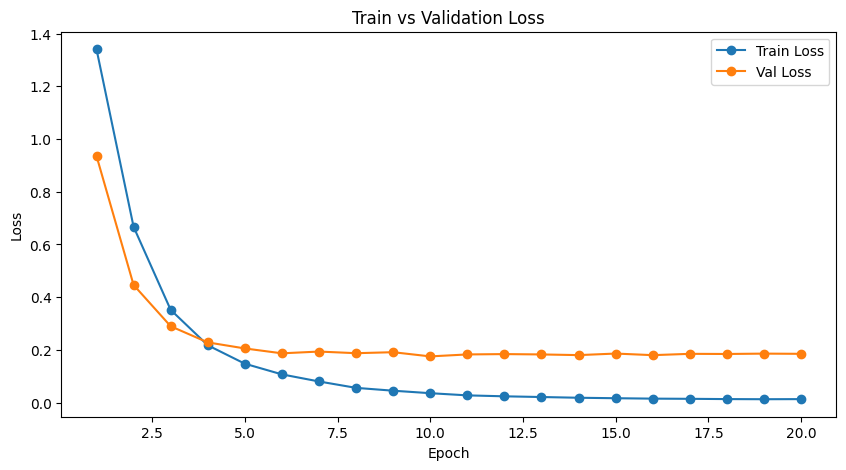

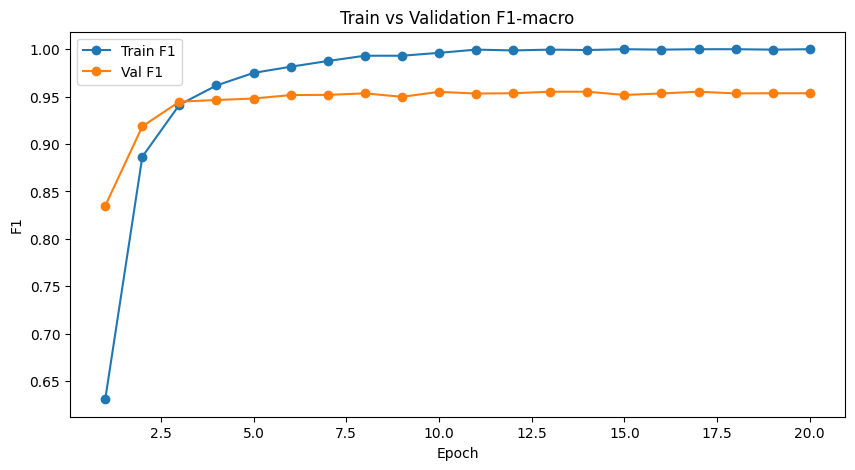


=== МЕТРИКИ НА ВАЛИДАЦИИ ===
Accuracy: 0.9527
Precision (macro): 0.9538
Recall (macro): 0.9540
F1-score (macro): 0.9536


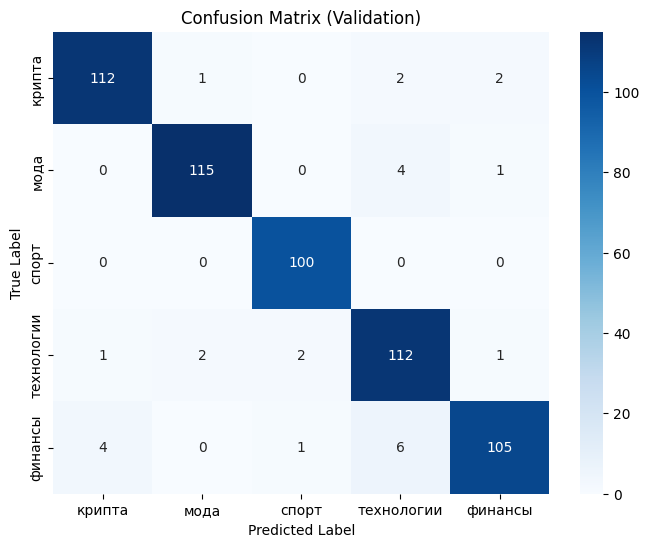


Пример: Mastercard планирует создать магазин для блокчейн-технологий.
➡️ Предсказанная категория: крипта (за 0.019 сек)


In [41]:

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import time

df = pd.read_feather('/content/drive/MyDrive/ds-phase-2/nlp_project/tg_channels.feather')
df = df.dropna(subset=['content', 'label'])

label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
num_labels = len(label_encoder.classes_)
print("Классы:", label_encoder.classes_)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'].tolist(), df['label_id'].tolist(),
    test_size=0.2, random_state=42, stratify=df['label']
)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2", num_labels=num_labels
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 20
num_training_steps = len(train_loader) * num_epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# обучение
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

for epoch in range(num_epochs):
    print(f"\n===== ЭПОХА {epoch+1}/{num_epochs} =====")

    # train
    model.train()
    total_train_loss = 0
    train_preds, train_labels_epoch = [], []

    for batch in tqdm(train_loader, desc="Обучение"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

        preds = outputs.logits.argmax(dim=1).detach().cpu().numpy()
        labels = batch["labels"].detach().cpu().numpy()
        train_preds.extend(preds)
        train_labels_epoch.extend(labels)

    train_loss = total_train_loss / len(train_loader)
    train_f1 = f1_score(train_labels_epoch, train_preds, average="macro")

    # val
    model.eval()
    val_preds, val_labels_epoch = [], []
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Валидация"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

            preds = outputs.logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            val_preds.extend(preds)
            val_labels_epoch.extend(labels)

    val_loss = total_val_loss / len(val_loader)
    val_f1 = f1_score(val_labels_epoch, val_preds, average="macro")

    # сохраняем статистику
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

epochs = range(1, num_epochs+1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1s, marker='o', label='Train F1')
plt.plot(epochs, val_f1s, marker='o', label='Val F1')
plt.title('Train vs Validation F1-macro')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.show()

# метрики на вал
acc = accuracy_score(val_labels_epoch, val_preds)
prec = precision_score(val_labels_epoch, val_preds, average='macro')
rec = recall_score(val_labels_epoch, val_preds, average='macro')
f1 = f1_score(val_labels_epoch, val_preds, average='macro')

print("\n=== МЕТРИКИ НА ВАЛИДАЦИИ ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro): {rec:.4f}")
print(f"F1-score (macro): {f1:.4f}")

# матрица ошибок
cm = confusion_matrix(val_labels_epoch, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Validation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# предсказания
def predict_text(text):
    model.eval()
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**tokens)
    pred = outputs.logits.argmax(dim=1).item()
    label = label_encoder.inverse_transform([pred])[0]
    return label

# пример
example = "Mastercard планирует создать магазин для блокчейн-технологий."
start = time.time()
pred_label = predict_text(example)
elapsed = time.time() - start
print(f"\nПример: {example}\nПредсказанная категория: {pred_label} (за {elapsed:.3f} сек)")


In [42]:
save_path = "/content/drive/MyDrive/ds-phase-2/nlp_project/rubert_tiny_model"

# сохраняем только веса и токенизатор
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/ds-phase-2/nlp_project/rubert_tiny_model/tokenizer_config.json',
 '/content/drive/MyDrive/ds-phase-2/nlp_project/rubert_tiny_model/special_tokens_map.json',
 '/content/drive/MyDrive/ds-phase-2/nlp_project/rubert_tiny_model/vocab.txt',
 '/content/drive/MyDrive/ds-phase-2/nlp_project/rubert_tiny_model/added_tokens.json',
 '/content/drive/MyDrive/ds-phase-2/nlp_project/rubert_tiny_model/tokenizer.json')